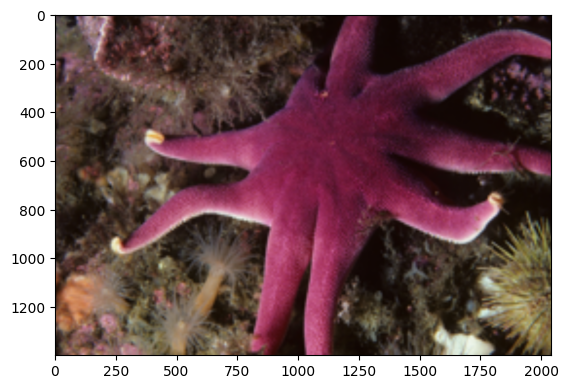

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function for super-resolution using ADMM
def admm_super_resolution(lr_image, max_iters=1000, lambda_tv=0.1, rho=1.0):
    # Get the dimensions of the low-resolution image
    lr_height, lr_width, channels = lr_image.shape

    # Scale factor (x8 in this case)
    scale_factor = 8
    hr_height = lr_height * scale_factor
    hr_width = lr_width * scale_factor

    # Upsample the low-resolution image to the high-resolution dimensions
    x = cv2.resize(lr_image, (hr_width, hr_height), interpolation=cv2.INTER_LINEAR)

    # Initialize z and u with the same shape as the high-resolution image
    z = np.copy(x)
    u = np.zeros_like(x)

    # ADMM loop
    for iteration in range(max_iters):
        # Update x: Data fidelity term + ADMM penalty
        x = (cv2.resize(lr_image, (hr_width, hr_height), interpolation=cv2.INTER_LINEAR) + rho * (z - u)) / (1 + rho)

        # Update z: Apply some form of regularization, for example, Total Variation (TV) regularization
        z = np.clip(x + u, 0, 255)  # Simple clipping, you can apply more sophisticated TV regularization

        # Update u: Dual variable update
        u = u + (x - z)

    return x

# Load the low-resolution image
lr_image_path = '0001x8.png'  # Replace with your actual image path
lr_image = cv2.imread(lr_image_path)

# Check if the image was loaded correctly
if lr_image is None:
    raise FileNotFoundError(f"Image not found at the path: {lr_image_path}")

# Perform super-resolution using ADMM
hr_estimated_image = admm_super_resolution(lr_image)

# Convert the high-resolution image to uint8 (for OpenCV operations)
hr_estimated_image_uint8 = np.clip(hr_estimated_image, 0, 255).astype(np.uint8)

# Convert BGR (OpenCV format) to RGB (for displaying with matplotlib)
hr_estimated_image_rgb = cv2.cvtColor(hr_estimated_image_uint8, cv2.COLOR_BGR2RGB)

# Show the result
plt.imshow(hr_estimated_image_rgb)
plt.show()


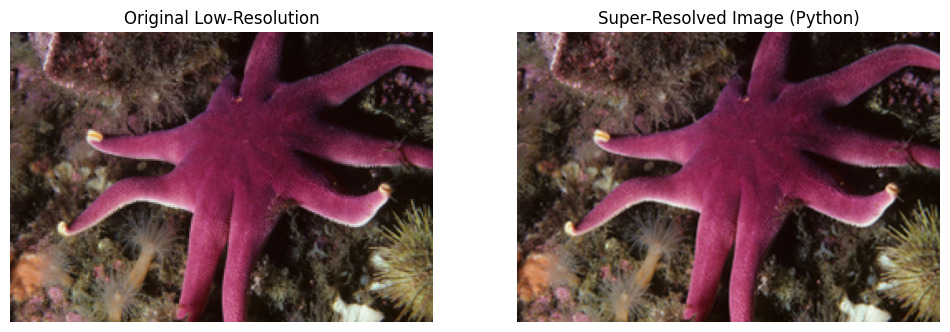

In [ ]:
import numpy as np
from skimage import io, transform
from skimage.restoration import denoise_tv_chambolle
import matplotlib.pyplot as plt

# Load low-resolution color image
low_res_path = '0001x8.png'
low_res_img = io.imread(low_res_path)

# Upsample the low-res image (e.g., 8x using bicubic interpolation) for each channel
scaling_factor = 8
high_res_initial = np.zeros((low_res_img.shape[0] * scaling_factor, low_res_img.shape[1] * scaling_factor, 3))
for c in range(3):  # Process each color channel (R, G, B)
    high_res_initial[..., c] = transform.resize(low_res_img[..., c],
                                                (low_res_img.shape[0] * scaling_factor, low_res_img.shape[1] * scaling_factor),
                                                order=3)

# ADMM parameters
lambda_reg = 0.1  # Regularization parameter
rho = 1.0         # ADMM penalty parameter
n_iter = 30       # Reduced number of iterations for efficiency

# Initialize variables for each color channel
x = high_res_initial.copy()
z = x.copy()
u = np.zeros_like(x)

# ADMM with TV regularization for each color channel
for i in range(n_iter):
    for c in range(3):  # Process each channel independently
        # Step 1: x-update (data fidelity term)
        x[..., c] = (high_res_initial[..., c] + rho * (z[..., c] - u[..., c])) / (1 + rho)

        # Step 2: z-update (apply total variation denoising with fewer iterations)
        z[..., c] = denoise_tv_chambolle(x[..., c] + u[..., c], weight=lambda_reg / rho, max_num_iter=5)

        # Step 3: u-update (dual variable update)
        u[..., c] = u[..., c] + x[..., c] - z[..., c]

# Plot results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original Low-Resolution")
plt.imshow(low_res_img)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Super-Resolved Image (Python)")
plt.imshow(z)
plt.axis('off')
plt.show()


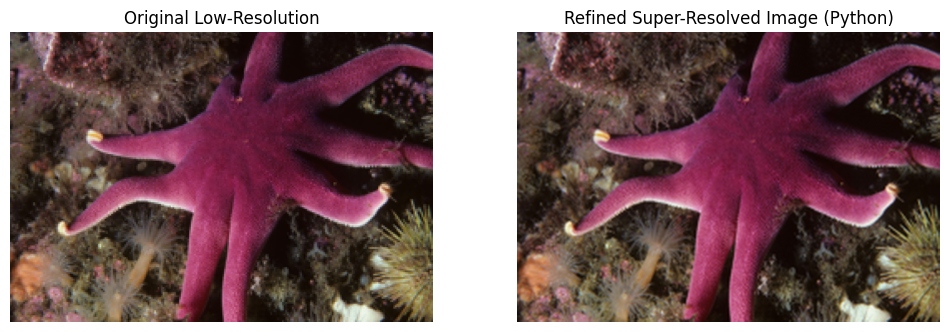

In [ ]:
import numpy as np
from skimage import io, transform
from skimage.restoration import denoise_tv_chambolle
import matplotlib.pyplot as plt

# Load low-resolution color image
low_res_path = '0001x8.png'  # Assuming this is the low-res input image
low_res_img = io.imread(low_res_path)

# Step 1: Bicubic Upscaling to Target Resolution
scaling_factor = 8
high_res_initial = np.zeros((low_res_img.shape[0] * scaling_factor, low_res_img.shape[1] * scaling_factor, 3))

for c in range(3):  # Process each color channel (R, G, B)
    high_res_initial[..., c] = transform.resize(low_res_img[..., c],
                                                (low_res_img.shape[0] * scaling_factor, low_res_img.shape[1] * scaling_factor),
                                                order=3)

# ADMM parameters
lambda_reg = 1  # Reduced regularization parameter for less aggressive smoothing
rho = 0.001          # Starting ADMM penalty parameter
n_iter = 20        # Moderate number of iterations

# Initialize variables for ADMM
x = high_res_initial.copy()
z = x.copy()
u = np.zeros_like(x)

# ADMM process for each color channel
for i in range(n_iter):
    for c in range(3):  # Process each channel independently
        # Step 1: x-update (data fidelity term)
        x[..., c] = (high_res_initial[..., c] + rho * (z[..., c] - u[..., c])) / (1 + rho)

        # Step 2: z-update (apply total variation denoising)
        # Use a lower max_num_iter in denoise_tv_chambolle for faster processing
        z[..., c] = denoise_tv_chambolle(x[..., c] + u[..., c], weight=lambda_reg / rho, max_num_iter=3)

        # Step 3: u-update (dual variable update)
        u[..., c] = u[..., c] + x[..., c] - z[..., c]

    # Optional: Gradually adjust `rho` to balance fidelity and smoothness
    rho = min(rho * 1.1, 10.0)  # Increase rho over iterations, but cap it

# Plot results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original Low-Resolution")
plt.imshow(low_res_img)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Refined Super-Resolved Image (Python)")
plt.imshow(z)
plt.axis('off')
plt.show()
